# ROI Presence Used Area overlap

Plots for used cells the amount of average area overlap per cell, based on the generated template image (histogram)

In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import gcsfs, pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from vr2p import styles

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Main Parameters

In [6]:
animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']
bin_size = 10

# Collect matched cell data.

This only uses clustered rois that passed the 'minimum presence'  test

In [ ]:
def collect_masks(animal):
    fs = gcsfs.GCSFileSystem(project='sprustonlab-meso')
    with fs.open(f'/.../registration/match-Tyche-{animal}.pkl', 'rb') as handle:
        matched_masks, matched_im, template_masks, template_im = pickle.load(handle)
    return {'animal':animal,'num_sessions': len(matched_im), 'matched_masks':matched_masks, 
            'matched_im':matched_im,'template_masks':template_masks,
            'template_im':template_im}
matched_info = [ collect_masks(animal) for animal in tqdm(animals)]

  0%|          | 0/11 [00:00<?, ?it/s]

# Collect hist data.

Note if animal does not have enough sessions to get data in one bin then it is ignored for that bin.

In [8]:
from itertools import permutations

data = []
for info in tqdm(matched_info):
    for template in info['template_masks']:
        mask_id = template['id']
        # find the matched masks with this id
        matched_masks = [matched_mask for matched_mask in info['matched_masks'] if matched_mask[0]['id']==mask_id]
        assert len(matched_masks)==1,'Found more then one possible matched mask'
        matched_masks = matched_masks[0]
        # get all possible combinations of pairs of matched masks (no repeats)
        matched_masks = list(permutations(matched_masks,2))
        overlap_perc = []
        for mask_pair in matched_masks:
            # get indices of pixels in each mask
            mask_a = mask_pair[0]['ipix']
            mask_b = mask_pair[1]['ipix']
            # find unique indices
            unique_pix = np.unique(np.concatenate((mask_a,mask_b)))
            num_pixels = len(unique_pix)
            # find overlap
            overlap_pix = np.intersect1d(mask_a, mask_b)
            overlap_perc.append((len(overlap_pix)/num_pixels)*100)
        overlap_perc = np.array(overlap_perc).mean()
        # store info.clear
        data.append({'animal':info['animal'],'mask_id':mask_id,'overlap_perc':overlap_perc})
# convert to dataframe
data = pd.DataFrame(data)
display(data)

  0%|          | 0/11 [00:00<?, ?it/s]

,animal,mask_id,overlap_perc
0,A4,1,76.717915
1,A4,2,77.579006
2,A4,3,80.571825
3,A4,4,71.865959
4,A4,5,82.496227
...,...,...,...
43491,F5,3961,73.143913
43492,F5,3962,68.554192
43493,F5,3963,65.861410
43494,F5,3964,71.621896


In [9]:
import math
# calculate histogram per animal
hist_data = []
for animal in animals:
    animal_data = data.loc[data['animal']==animal,'overlap_perc'].to_numpy()
    hist_values,bins = np.histogram(animal_data,np.arange(0,100+bin_size,bin_size))
    hist_data.append([(hist_values/hist_values.sum())*100])
result = np.vstack(hist_data)
result_m = np.nanmean(result,axis=0)
result_std = np.nanstd(result,axis=0)
result_sem = result_std/math.sqrt(len(animals))

# Plot histogram

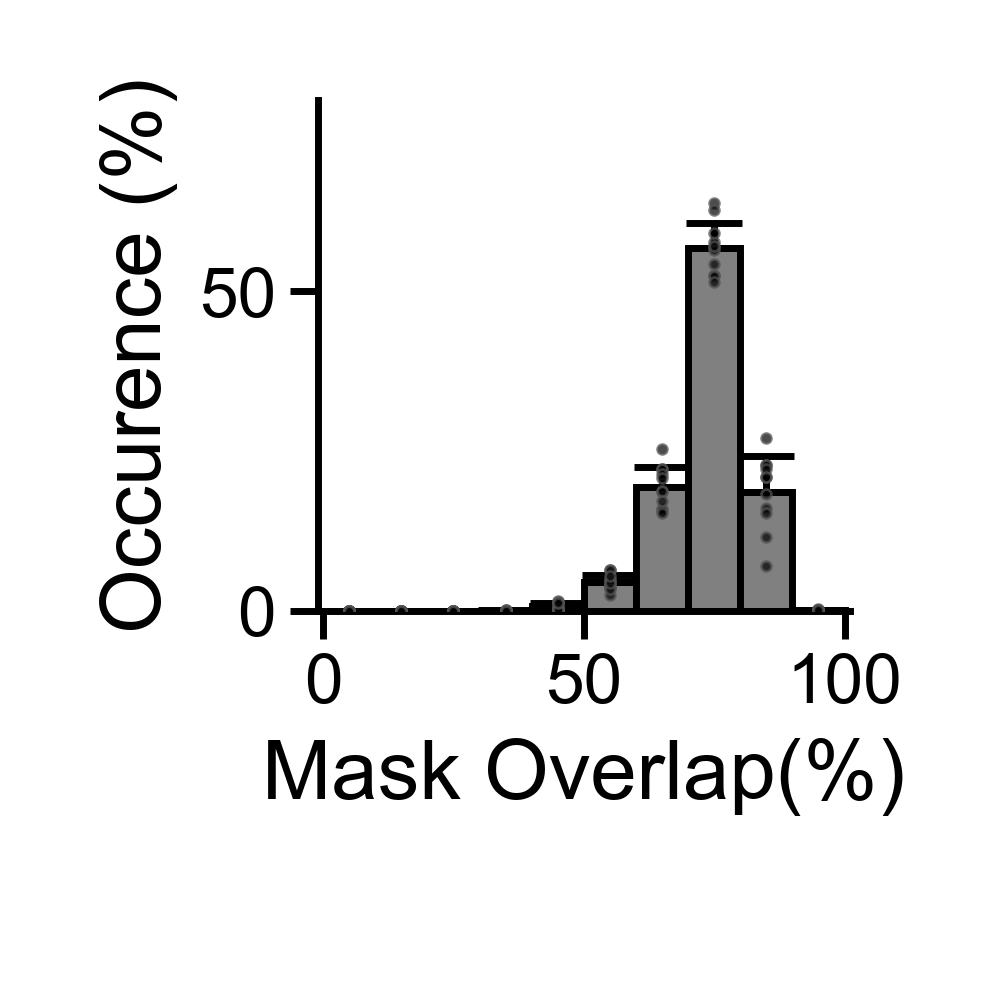

In [29]:
plt.style.use(styles('publication-tight'))
# plot
axs = plt.figure(figsize=(22.5/25.4 ,22.5/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['plot'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1,],
    # set the width ratios between the columns
    width_ratios=[1],
)
ax = axs['plot']
x_pos = np.arange(0+(bin_size/2), 100,bin_size)
ax.bar(x_pos, result_m,width=bin_size/1, color='gray',edgecolor='black',linewidth=0.5)
y_err = np.array([ [0,err] for err in result_std]).T
ax.errorbar(x_pos,result_m,
           yerr = y_err,fmt='none',solid_capstyle='projecting',
            capsize=2,color='black',capthick=0.5,elinewidth=0.5)
# set x ticks
ax.set_xticks(np.arange(0,101,50))
ax.set_xlim(-1,101)
ax.set_xlabel('Mask Overlap(%)\n')
ax.set_ylabel('Occurence (%)')
# add dots for each animal per bin.
for i in range(len(animals)):
    animal_data = result[i]
    scatter = ax.scatter(x_pos, animal_data, s=0.5, c='black', alpha=0.7, edgecolor='#555555', linewidth=0.2, zorder=1000)


In [11]:
print(result.shape)

(11, 10)
